
# Cycle Graph → Exact Min-Sum Jacobian (raw vs. difference) → Message Dependency

This notebook matches the **hard-min** (no softmin) formulation and the **difference** calculus from the paper.

We use a 3-variable ring (binary labels) with the cost tables from the worked example:

- $$C_{01}=\begin{bmatrix}0&3\\ 2&0\end{bmatrix}$$,
- $$C_{12}=\begin{bmatrix}0&2\\ 4&1\end{bmatrix}$$,
- $$C_{20}=\begin{bmatrix}0&2\\ 1&3\end{bmatrix}$$.

Visualizations:
1. Factor graph (bipartite).
2. Jacobian without difference-normalization (raw K-state messages, hard **min** selectors).
3. Jacobian with **per-message difference** normalization (apply \(Q=I-\frac{1}{K}\mathbf{1}\mathbf{1}^\top\) to outputs).
4. Binary **difference** Jacobian (size \(12\times 12\) here) and its message dependency digraph.


In [1]:

# Deps
import sys, subprocess
try:
    import networkx as nx  # noqa: F401
except Exception:
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "networkx"])

import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

np.set_printoptions(precision=3, suppress=True)
%matplotlib inline


In [2]:

# Problem setup: 3-variable ring, binary labels K=2
K = 2
variables = ["X0", "X1", "X2"]
factors = {
    "F01": ("X0", "X1"),
    "F12": ("X1", "X2"),
    "F20": ("X2", "X0"),
}

# Cost tables (rows = xi in {0,1}, cols = xj in {0,1})
C = {
    "F01": np.array([[0,3],[2,0]], dtype=float),
    "F12": np.array([[0,2],[4,1]], dtype=float),
    "F20": np.array([[0,2],[1,3]], dtype=float),
}

# Build neighbor maps
var_neighbors = {v: [] for v in variables}
for f, (a, b) in factors.items():
    var_neighbors[a].append(f)
    var_neighbors[b].append(f)

# Utility: difference projection Q = I - (1/K) 11^T
def difference_projection(K: int) -> np.ndarray:
    I = np.eye(K)
    return I - np.ones((K, K)) / K

Qproj = difference_projection(K)


## 1) Factor graph (NetworkX + Matplotlib)

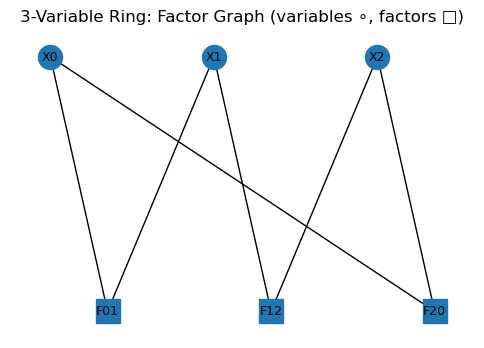

In [3]:

G = nx.Graph()
for x in variables:
    G.add_node(x, kind='var')
for f in factors:
    G.add_node(f, kind='fac')
for f, (a,b) in factors.items():
    G.add_edge(a, f)
    G.add_edge(b, f)

pos = {}
xstep = 2.0
for i, x in enumerate(variables):
    pos[x] = (i*xstep, 1.0)
for j, f in enumerate(factors):
    pos[list(factors.keys())[j]] = (j*xstep+0.7, 0.0)

plt.figure(figsize=(6,4))
nx.draw_networkx_nodes(G, pos, nodelist=variables, node_shape='o')
nx.draw_networkx_nodes(G, pos, nodelist=list(factors.keys()), node_shape='s')
nx.draw_networkx_edges(G, pos)
nx.draw_networkx_labels(G, pos, font_size=9)
plt.title("3-Variable Ring: Factor Graph (variables ∘, factors □)")
plt.axis('off')
plt.show()



## 2) Exact hard-min Jacobian (raw K-state messages)

We build the Jacobian of one synchronous Min–Sum sweep with **hard min** selectors.
- **Factor→variable** block from $Q_{j\to f}$ to $R_{f\to i}$: selector matrix $S$ with one 1 per row (chosen column), no recentering.
- **Variable→factor** block from $R_{g\to i}$ to $Q_{i\to f}$: identity $I_K$ for each $g\in \mathcal{N}(i)\\setminus\\{f\\}$.


In [4]:

# Message lists (raw K-state vectors)
msg_v2f = []   # variable->factor messages
msg_f2v = []   # factor->variable messages
for f,(i,j) in factors.items():
    msg_v2f += [f"{i}->{f}", f"{j}->{f}"]
    msg_f2v += [f"{f}->{i}", f"{f}->{j}"]

all_msgs = msg_v2f + msg_f2v
msg_idx = {m: idx for idx, m in enumerate(all_msgs)}
Mdim = len(all_msgs)*K

def block_indices(m_out, m_in):
    ro = msg_idx[m_out]*K
    ci = msg_idx[m_in]*K
    return slice(ro, ro+K), slice(ci, ci+K)

def select_columns_for_factor(f, i, j, Q_in=None):
    # Q_in: current Q_{j->f} vector; if None -> zeros (tie-free here due to costs)
    if Q_in is None:
        Q_in = np.zeros(K)
    # For each row x_i, choose argmin over x_j of C[irow, jcol] + Q_in[jcol]
    S = np.zeros((K, K))
    for xi in range(K):
        scores = C[f][xi, :] + Q_in
        t = int(np.argmin(scores))  # unique for these costs at Q=0
        S[xi, t] = 1.0
    return S

def build_J_raw():
    J = np.zeros((Mdim, Mdim))
    # Factor->variable rows depend only on opposite var->fac along same factor
    for f,(i,j) in factors.items():
        # f->i depends on j->f
        S_fi = select_columns_for_factor(f, i, j, Q_in=None)  # KxK selector
        rsl, csl = block_indices(f"{f}->{i}", f"{j}->{f}")
        J[rsl, csl] = S_fi  # no difference-normalization here

        # f->j depends on i->f
        S_fj = select_columns_for_factor(f, j, i, Q_in=None)
        rsl, csl = block_indices(f"{f}->{j}", f"{i}->{f}")
        J[rsl, csl] = S_fj

    # Variable->factor rows: sums of R from other factors into the same variable
    for f,(i,j) in factors.items():
        # i->f depends on all g->i, g != f
        for g in var_neighbors[i]:
            if g == f: 
                continue
            rsl, csl = block_indices(f"{i}->{f}", f"{g}->{i}")
            J[rsl, csl] = np.eye(K)
        # j->f depends on all g->j, g != f
        for g in var_neighbors[j]:
            if g == f: 
                continue
            rsl, csl = block_indices(f"{j}->{f}", f"{g}->{j}")
            J[rsl, csl] = np.eye(K)
    return J

J_raw_full = build_J_raw()
J_raw_full.shape


(24, 24)

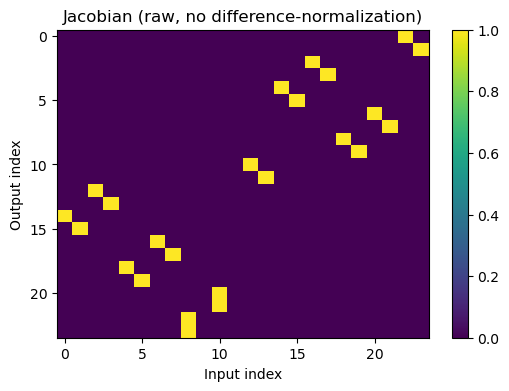

In [5]:

plt.figure(figsize=(6,4))
plt.imshow(J_raw_full, aspect='auto')
plt.colorbar()
plt.title("Jacobian (raw, no difference-normalization)")
plt.xlabel("Input index")
plt.ylabel("Output index")
plt.show()



## 3) Exact hard-min Jacobian with **per-message difference**

We apply the projection $Q=I-\frac{1}{K}\mathbf{1}\mathbf{1}^\top$ **to every output block** to model recentering of each message.


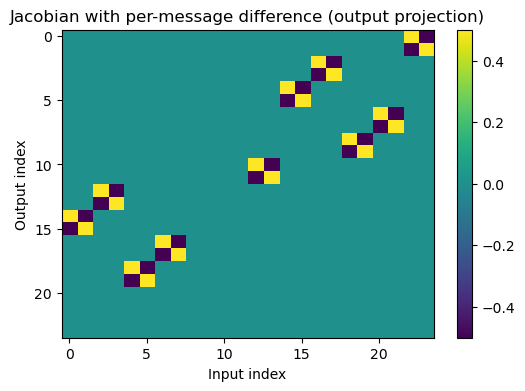

In [6]:

# Apply Q projection to each message's output rows
def apply_output_difference(J_full: np.ndarray, K: int) -> np.ndarray:
    J = J_full.copy()
    for m in all_msgs:
        rsl = slice(msg_idx[m]*K, msg_idx[m]*K+K)
        J[rsl, :] = Qproj @ J[rsl, :]
    return J

J_diff_full = apply_output_difference(J_raw_full, K)
plt.figure(figsize=(6,4))
plt.imshow(J_diff_full, aspect='auto')
plt.colorbar()
plt.title("Jacobian with per-message difference (output projection)")
plt.xlabel("Input index")
plt.ylabel("Output index")
plt.show()



## 4) Binary **difference** Jacobian (\(12\times 12\)) and dependency graph

For binary labels we switch to scalar **differences** per message:
- Variable update rows: \(+1\) from each \(R_{g\to i}\) into \(Q_{i\to f}\) for \(g\ne f\).
- Factor update rows: sign in \(\{-1,0,1\}\) from \(\Delta Q_{j\to f}\) to \(\Delta R_{f\to i}\):
    - \(+1\) if rows select \((t_1,t_0)=(1,0)\),
    - \(-1\) if \((t_1,t_0)=(0,1)\),
    - \(0\) if neutral (both rows select same column).
Selectors are computed at \(Q=0\) (tie-free here).


In [7]:

# Order binary-difference coordinates to match the paper's 12-dim stacking
order_d = [
    "dR_F01->X0","dR_F01->X1",
    "dR_F12->X1","dR_F12->X2",
    "dR_F20->X2","dR_F20->X0",
    "dQ_X0->F01","dQ_X1->F01",
    "dQ_X1->F12","dQ_X2->F12",
    "dQ_X2->F20","dQ_X0->F20"
]
idx_d = {m:i for i,m in enumerate(order_d)}
Ddim = len(order_d)

def factor_sign(f, target_i, other_j):
    # selectors at Q=0
    S = select_columns_for_factor(f, target_i, other_j, Q_in=np.zeros(K))
    # For binary, row 0 col chosen = argmax S[0], similarly row 1
    t0 = int(np.argmax(S[0]))
    t1 = int(np.argmax(S[1]))
    if (t1, t0) == (1,0):
        return +1.0
    elif (t1, t0) == (0,1):
        return -1.0
    else:
        return 0.0  # neutral

def build_J_binary_diff():
    J = np.zeros((Ddim, Ddim))
    # Factor rows
    # F01->X0 depends on dQ_X1->F01
    J[idx_d["dR_F01->X0"], idx_d["dQ_X1->F01"]] = factor_sign("F01","X0","X1")
    # F01->X1 depends on dQ_X0->F01
    J[idx_d["dR_F01->X1"], idx_d["dQ_X0->F01"]] = factor_sign("F01","X1","X0")
    # F12
    J[idx_d["dR_F12->X1"], idx_d["dQ_X2->F12"]] = factor_sign("F12","X1","X2")
    J[idx_d["dR_F12->X2"], idx_d["dQ_X1->F12"]] = factor_sign("F12","X2","X1")
    # F20
    J[idx_d["dR_F20->X2"], idx_d["dQ_X0->F20"]] = factor_sign("F20","X2","X0")
    J[idx_d["dR_F20->X0"], idx_d["dQ_X2->F20"]] = factor_sign("F20","X0","X2")

    # Variable rows: each dQ depends on other incoming dR
    # dQ_X0->F01 depends on dR_F20->X0
    J[idx_d["dQ_X0->F01"], idx_d["dR_F20->X0"]] = 1.0
    # dQ_X1->F01 depends on dR_F12->X1
    J[idx_d["dQ_X1->F01"], idx_d["dR_F12->X1"]] = 1.0
    # dQ_X1->F12 depends on dR_F01->X1
    J[idx_d["dQ_X1->F12"], idx_d["dR_F01->X1"]] = 1.0
    # dQ_X2->F12 depends on dR_F20->X2
    J[idx_d["dQ_X2->F12"], idx_d["dR_F20->X2"]] = 1.0
    # dQ_X2->F20 depends on dR_F12->X2
    J[idx_d["dQ_X2->F20"], idx_d["dR_F12->X2"]] = 1.0
    # dQ_X0->F20 depends on dR_F01->X0
    J[idx_d["dQ_X0->F20"], idx_d["dR_F01->X0"]] = 1.0
    return J

J_bin = build_J_binary_diff()
J_bin


array([[0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

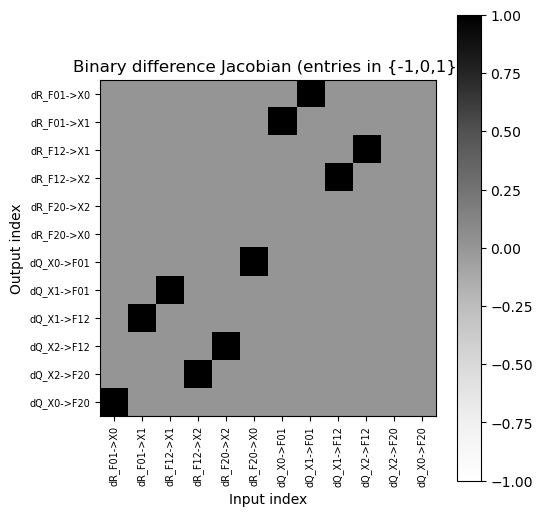

In [8]:

plt.figure(figsize=(5.5,5.5))
plt.imshow(J_bin, cmap='Greys', vmin=-1, vmax=1)
plt.colorbar()
plt.title("Binary difference Jacobian (entries in {-1,0,1})")
plt.xlabel("Input index")
plt.ylabel("Output index")
plt.yticks(range(Ddim), order_d, fontsize=7)
plt.xticks(range(Ddim), order_d, fontsize=7, rotation=90)
plt.tight_layout()
plt.show()


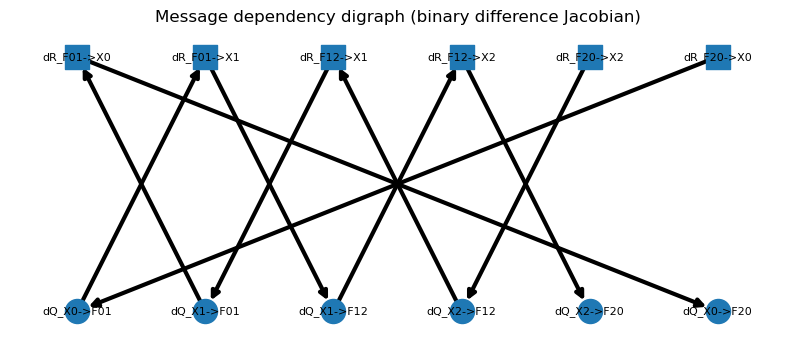

In [9]:

# Build dependency digraph from J_bin (nonzeros)
H = nx.DiGraph()
H.add_nodes_from(order_d)
for i_out, m_out in enumerate(order_d):
    for j_in, m_in in enumerate(order_d):
        w = J_bin[i_out, j_in]
        if abs(w) > 1e-9:
            H.add_edge(m_in, m_out, weight=w)

# Layout: split by type (dQ vs dR)
Q_nodes = [n for n in order_d if n.startswith("dQ_")]
R_nodes = [n for n in order_d if n.startswith("dR_")]

pos = {}
x_step = 1.6
for i, n in enumerate(Q_nodes):
    pos[n] = (i * x_step, 0.0)
for j, n in enumerate(R_nodes):
    pos[n] = (j * x_step, 1.0)

plt.figure(figsize=(10,4))
nx.draw_networkx_nodes(H, pos, nodelist=Q_nodes, node_shape='o')
nx.draw_networkx_nodes(H, pos, nodelist=R_nodes, node_shape='s')
# edge widths by |w|, sign by style
edges = H.edges(data=True)
widths = [1.0 + 2.0*min(1.0, abs(d['weight'])) for _,_,d in edges]
nx.draw_networkx_edges(H, pos, width=widths, arrows=True, arrowstyle='-|>', arrowsize=12)
nx.draw_networkx_labels(H, pos, font_size=8)
plt.title("Message dependency digraph (binary difference Jacobian)")
plt.axis('off')
plt.show()


## 5) Inspect selectors and signs

In [10]:

def selectors_report():
    rows = []
    for f,(i,j) in factors.items():
        S_fi = select_columns_for_factor(f, i, j, Q_in=np.zeros(K))
        S_fj = select_columns_for_factor(f, j, i, Q_in=np.zeros(K))
        s_fi = factor_sign(f, i, j)
        s_fj = factor_sign(f, j, i)
        rows.append((f"{f}->{i}", S_fi.astype(int), s_fi))
        rows.append((f"{f}->{j}", S_fj.astype(int), s_fj))
    return rows

for name, S, sgn in selectors_report():
    print(name, "selector rows=\n", S, " sign=", sgn, "\n")


F01->X0 selector rows=
 [[1 0]
 [0 1]]  sign= 1.0 

F01->X1 selector rows=
 [[1 0]
 [0 1]]  sign= 1.0 

F12->X1 selector rows=
 [[1 0]
 [0 1]]  sign= 1.0 

F12->X2 selector rows=
 [[1 0]
 [0 1]]  sign= 1.0 

F20->X2 selector rows=
 [[1 0]
 [1 0]]  sign= 0.0 

F20->X0 selector rows=
 [[1 0]
 [1 0]]  sign= 0.0 



## not lets inspect the difference jacobian again, and how to make it nilpotent
- the current jacobian is:


In [11]:
print(J_bin)

[[0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
